# **Attention Transformers: BERT**

Hi! In this lab, you will learn how to use BERT (**Bidirectional Encoder Representations from Transformers**) model for a quotes classification task.

**GPU** is recomended for this assignment. `Runtime` -> `Change runtime type` -> `GPU`

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to build a custom BERT transformer
    - How to preprocess text dataset for BERT model
    - How to create a custom PyTorch dataset
    - How to train and evaluate transformer model for a classification NLP task
    - How to visualize the results using TensorBoard

# **Download data**

In [1]:
!pip install wget
import wget 
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/datasets/07_attention_transformers/Bert/Quotes_dataset.csv')


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


'Quotes_dataset (1).csv'

# **Import packages**

Here we will import our regular packages with the addition of [transformers](https://huggingface.co/docs/transformers/index), which provides APIs to download and train state-of-the-art pretrained models quickly. In this lab, we will use a pre-trained model like `BertModel` and `BertTokenizer` for the tokenization task.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch.optim import Adam
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

!pip install transformers==4.17.0
import transformers
from transformers import BertModel, BertTokenizer


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# **Data Preprocessing and visualizations**

For our dataset, we will be using the [Quotes dataset](https://www.kaggle.com/abdokamr/good-reads-quotes) from [Kaggle](https://www.kaggle.com). This dataset contains ~3000 quotes from each quote class (quotes of death, quotes of humor, etc.). We will use just a sample of the original dataset with 5 classes. Our task will be to classify the quote tag by text.

## Load the data

In [3]:
data = pd.read_csv('Quotes_dataset.csv')
data.head(5)

,quotes,tag
0,"To the well-organized mind, death is but the n...",quotes_of_death
1,"I wish it need not have happened in my time,"" ...",quotes_of_death
2,I'm the one that's got to die when it's time f...,quotes_of_death
3,The fear of death follows from the fear of lif...,quotes_of_death
4,"I DON'T CARE!"" Harry yelled at them, snatching...",quotes_of_death


## Data Visualization

Let's visualize how many quotes from each class we have:

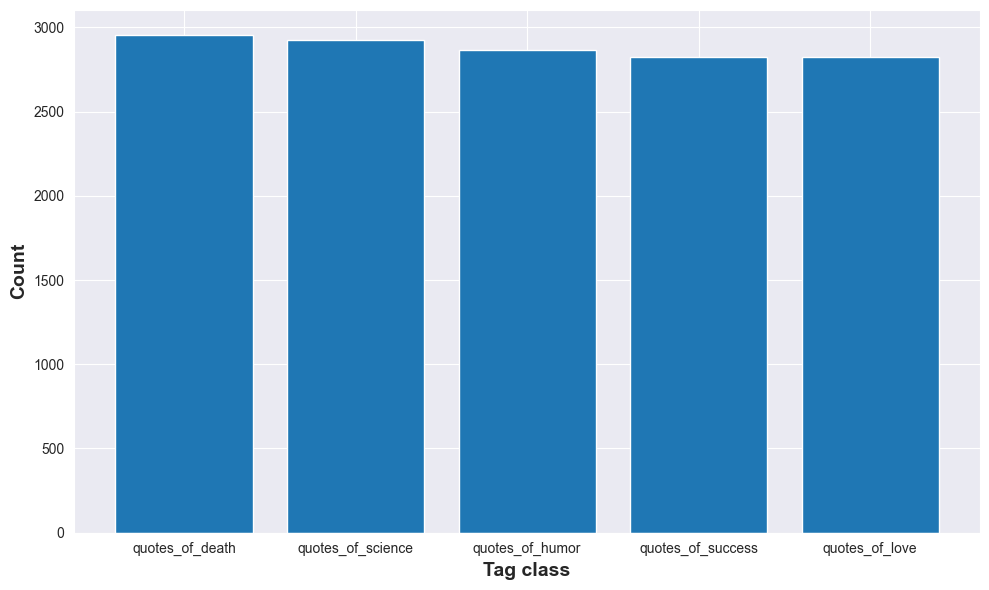

In [4]:
plt.figure(figsize=(10, 6))
class_counts = data.tag.value_counts()
plt.bar(class_counts.index, class_counts.to_list())
plt.xticks(np.arange(5), data["tag"].unique())
plt.xlabel('Tag class', fontweight='bold', fontsize=14.0)
plt.ylabel('Count', fontweight='bold', fontsize=14.0 )
plt.tight_layout()
plt.show()

## Config

In `Config` class, we will define standard hyperparameters for training. There are also a few additional hyperparameters: <br><br>

**Model Config**
- **model_name** - is a case-sensitive BERT model, which makes a difference between 'Hello' and 'hello'.
- **max_len** - specifies the length of the tokenized text
- **hidden_size** - is the number of hidden units in the feedforward-network

**Data Preparation**
- **test_fraction** - the fraction of the whole dataset that will be used for the final evaluation
- **validation_fraction** - the fraction of the entire dataset that will be used for validating model performance during training
- **num_workers** - denotes the number of processes that generate batches in parallel
- **classes** - the names of the tags that we will classify
- **tags_map** - is a dict with classes names and their encoded labels
- **logdir** - is the directory you will create data to visualize in TensorBoard.


In [5]:
# VALIDATION_FIELD[cls] Config

class Config:

    # Model Config
    model_name = 'bert-base-cased'
    max_len = 128
    hidden_size = 768

    # Data preparation
    test_fraction = 0.1
    validation_fraction = 0.1
    batch_size = 16
    num_workers = 2
    classes = ('quotes_of_death', 'quotes_of_science', 'quotes_of_humor', 'quotes_of_success', 'quotes_of_love')
    tags_map = {cls:i for i,cls in enumerate(classes)}
    logdir = 'logdir'

    # Training
    seed = 21
    epochs = 5
    learning_rate = 1e-6
    num_classes = len(classes)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
def set_seed(seed):
    np.random.seed(seed) 
    torch.manual_seed(seed)

set_seed(Config.seed)

## **Transformers What Is It?**
The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. Transformers are a new type of neural network aimed at **solving sequences with easy processing of long-range dependencies**.

Unlike recurrent neural networks (**RNNs**), transformers do not process sequences in order. In a way, the transformer model is non-directional. For example, if the source data is text, they do not need to process the end of the sentence after processing the beginning. So, a transformer neural network can be parallelized and trained much faster.

[The Transformer architecture](https://machinelearningmastery.com/the-transformer-model/) has an **encoder-decoder** structure. The **encoder** maps an input sequence `X`=$(x_1,x_2,..,x_n)$  into an abstract continuous representation `z`=$(z_1,z_2,..,z_n)$  that holds all the learned information of that input. The **decoder** then takes that continuous representation `z` and, step by step, generates an output sequence `Y`=$(y_1,y_2,..,y_m)$  of symbols one element at a time, consuming the previously generated symbols as additional input when generating the next.
  

## **Preprocessing & Tokenization**
Before using your data in a model, data needs to be processed into an acceptable format. A model does not understand raw text, images or audio. So inputs need to be converted into numbers.

The primary tool for processing textual data is a [tokenizer](https://huggingface.co/docs/transformers/master/en/main_classes/tokenizer). A tokenizer splits text into *tokens*, which are part of a fixed vocabulary. The tokens are converted into numbers, which are used to build tensors as input to a model.

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/tokenization.png">

## **Embeddings**
Tokens are converted into [embedding vectors](https://medium.com/deeper-learning/glossary-of-deep-learning-word-embedding-f90c3cec34ca) using a fixed representation like word2vec or any other. An embedding captures the input semantics by placing semantically similar inputs close together in the embedding space.

## **Positional Encodings**
Converting a sequence into tokenization, you lose the notion of order. The neural network cannot understand any order in a set of tokens. [The positional encoders](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) receive inputs from the input embeddings layer and apply relative positional information. This layer outputs word vectors with positional information. In other words, it is the word’s meaning and its context in the sentence.

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/positional_encoding.png">

## **Attention**
LSTMs and RNNs present 3 problems:
- Processing word by word inhibits parallelization
- There is no explicit model of long and short-range dependencies
- The model often forgets the content of distant positions in the sequence for long sentences

So was created a technique to solve some of these problems by paying [attention](https://arxiv.org/pdf/1706.03762.pdf) to specific words. Neural networks can focus on the part of a subset of the information they are given. For example, imagine that you are in a large crowd of people. You can recognize your name being spoken by someone in a crowd, even if it should get lost in all the other noise. Your brain can focus on necessary things and filter out unnecessary information.

Vanilla attention uses a linear combination of previously hidden vectors in the input sequence or a sentence in the case of a sequence-to-sequence model. This combination of hidden vectors is concatenated with the current word's vector and fed to the next layer of the model. [Here](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) you can find a more detailed explanation of attention with informative gifs.

## **Self-Attention**
[Self-attention](https://jalammar.github.io/illustrated-transformer/) is a new step in the attention technique. Instead of looking at prior hidden vectors when considering a word embedding, self-attention is a weighted combination of all other word embeddings.

## **Multi-Headed Attention**
[Multi-headed attention](https://jalammar.github.io/illustrated-transformer/) is a further innovation that gives the transformer greater power to encode multiple relationships for each word. The idea is that by repeating the self-attention mechanism multiple times, the model can learn to separate different kinds of useful semantic information into other channels.

## **Outputs**

- There are two output layers: a linear layer followed by a softmax layer. The linear layer performs a decompression task: it takes the final encoded representation for the output word. It turns it around into log-odds for each word in the recipient language's vocabulary. A softmax running on this then turns that into probabilities, and we take an `argmax` of that — standard stuff for a language generation model.
- The loss function is the cross-entropy of KL divergence.
- As an optimization, beam search is also possible: take the top $𝑁$ most likely words and continue searching through the sentence with lookahead.

## **NLP Tasks Transformers Can Solve**

- ### MLM (Masked Language Modeling)
    This transformer architecture involves masking part of the input and then learning a model to predict the missing tokens - essentially reconstructing the non-masked input. MLM is often used within pretraining tasks to allow models to learn textual patterns from unlabeled data.

- ### NSP (Next Sentence Prediction)
    In this transformer architecture, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. During training, 50% of the inputs are a pair in which the second sentence is the subsequent sentence in the original document, while in the other 50%, a random sentence from the corpus is chosen as the second sentence. The assumption is that the random sentence will be disconnected from the first sentence.
- ### SC (Sequence Classification)
    Sequence classification is a DP technique in NLP to classify the type of text into a particular category. These categories depend on the type of task they perform. Examples include sentiment analysis, topic labelling, spam detection, and intent detection.
- ### QA (Question Answering)
    Question Answering aims to find the answer to a question given a question and an accompanying context. The predicted answer will be either a span of text from the context or an empty string (indicating the question cannot be answered from the context).

## Data Preprocessing

Some BERT's model requirements for text preprocessing:
- Add special tokens to separate sentences for doing classification.
- Pass sequences using constant length.
- Create an *attention mask* array consisting of 0s (pad token) and 1s (real token).

We will use the transformers library, including prebuild tokenizers that help us process our text easily and quickly!

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

> We will use a cased version of BERT and tokenizer - `bert-base-cased`.

In [7]:
# VALIDATION_FIELD[func] tokenizer

tokenizer = BertTokenizer.from_pretrained(Config.model_name)

Let's use some text to understand the tokenization process clearly:

In [8]:
sample_text = 'Success is not final; failure is not fatal: It is the courage to continue that counts.'

Here are some basic operations to convert our sample text to tokens and tokens to unique ids:

In [9]:
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Original sentence: {sample_text}')
print(f'Tokenized sentence: {tokens}')
print(f'Token IDs: {token_ids}')

Original sentence: Success is not final; failure is not fatal: It is the courage to continue that counts.
Tokenized sentence: ['Success', 'is', 'not', 'final', ';', 'failure', 'is', 'not', 'fatal', ':', 'It', 'is', 'the', 'courage', 'to', 'continue', 'that', 'counts', '.']
Token IDs: [25911, 1110, 1136, 1509, 132, 4290, 1110, 1136, 11874, 131, 1135, 1110, 1103, 9163, 1106, 2760, 1115, 10664, 119]


### Special Tokens

BERT uses special tokens:

- `[SEP]` - indicates the end of a sentence
- `[CLS]` - is a special classification token, so we add this token to the start of each sentence.
- `[PAD]` - is a special token for padding.
- `[UNK]` - uses for tokens not appearing in the training vocabulary, so they should be replaced with a special token `[UNK]`, which stands for unknown token.

In [10]:
print(f'Token:{tokenizer.sep_token}, token id:{tokenizer.sep_token_id}')
print(f'Token:{tokenizer.cls_token}, token id:{tokenizer.cls_token_id}')
print(f'Token:{tokenizer.pad_token}, token id:{tokenizer.pad_token_id}')
print(f'Token:{tokenizer.unk_token}, token id:{tokenizer.unk_token_id}')

Token:[SEP], token id:102
Token:[CLS], token id:101
Token:[PAD], token id:0
Token:[UNK], token id:100


All this can be combined using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [11]:
encoding = tokenizer.encode_plus(
  sample_text, # The sentence to be encoded
  max_length=32, # Maximum length of a sentence
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False, # Don't return token type ids
  padding='max_length', # Pad sentence to max length
  return_attention_mask=True, # Generate the attention mask
  return_tensors='pt',  # Return PyTorch tensors
)

# Let's get the sample text IDs and attention mask in tensor format
input_ids = encoding['input_ids']
attn_mask = encoding['attention_mask']
ids_to_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print(f'Input IDs: {input_ids}')
print(f'Attention mask: {attn_mask}')
print(f'Padded text length: {len(input_ids[0])}')

Input IDs: tensor([[  101, 25911,  1110,  1136,  1509,   132,  4290,  1110,  1136, 11874,
           131,  1135,  1110,  1103,  9163,  1106,  2760,  1115, 10664,   119,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
Attention mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
Padded text length: 32


# **Choosing Sequence Length**

BERT model works with fixed-length sequences. So, we need to choose the max length we will use.

**Excercise:** implement function `get_token_lens`


- **Hint**: use `tokenizer.encode` to encode quote text with parameters `max_length=512` and `truncation=True`




In [12]:
# VALIDATION_FIELD[func] get_token_lens

def get_token_lens(df):
    """
    Calculates the token length of each quote in DataFrame

    Arguments:
    df -- Pandas DataFrame of quotes and their tags
    
    Return:
    token_lens -- 1-D np.array of integers that represents tokens lengths of quotes
    """

    token_lens = []

    ### START CODE HERE ### (≈ 4 lines of code)
    for quote in df.quotes:
        encoded_quote = tokenizer.encode(quote, max_length=512, truncation=True)
        token_lens.append(len(encoded_quote))
    
    return np.array(token_lens)
    ### END CODE HERE ###

In [13]:
sample_df = data.iloc[:5].copy()
sample_df_token_lens = get_token_lens(sample_df)
print('Token lens: ', sample_df_token_lens)

Token lens:  [ 17  68  35  26 142]


**Expected output:**
    
<table>
    <tr>
        <td><b>Token lens:</b></td>
        <td>[ 17  68  35  26 142]</td>
    </tr>
    
</table>

Let's visualize tokens size distribution for all quotes:

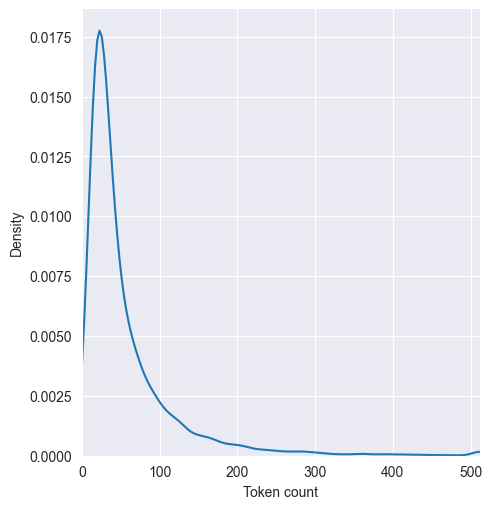

In [14]:
token_lens_list = get_token_lens(data)

sns.displot(token_lens_list, kind="kde")
plt.xlim([0, 512]);
plt.xlabel('Token count');

Let's try to take the length of the power of two: 128. Most of the quotes seem to contain less than 128 tokens :) We will select those with a token length less than our chosen length from our dataset.

**Excercise:** implement function `select_rows_with_required_token_lens`

**Hints**:
- create a new column `token_len` for `df`, where will be the token length for each quote
- select rows with `token_len` less than `Config.max_len`. Don't forget to use `reset_index(drop=True)`


In [15]:
# VALIDATION_FIELD[func] select_rows_with_required_token_lens

def select_rows_with_required_token_lens(df, max_len=Config.max_len):
    """
    Selects rows from DataFrame with quotes token length less than max_len

    Arguments:
    df -- Pandas DataFrame of quotes and their tags
    
    Return:
    New DataFrame that has quotes tokens lengths less than max_len
    """

    ### START CODE HERE ### (≈3 lines of code)
    df['token_len'] = get_token_lens(df)
    new_df = df[df.token_len < max_len].reset_index(drop=True)
    return new_df
    ### END CODE HERE ###

In [16]:
new_sample_df = select_rows_with_required_token_lens(sample_df)
new_sample_df

,quotes,tag,token_len
0,"To the well-organized mind, death is but the n...",quotes_of_death,17
1,"I wish it need not have happened in my time,"" ...",quotes_of_death,68
2,I'm the one that's got to die when it's time f...,quotes_of_death,35
3,The fear of death follows from the fear of lif...,quotes_of_death,26


**Expected output:**
    
<table>
<tbody>
<tr style="height: 23px;">
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;quotes</td>
<td style="height: 23px;">&nbsp;tag</td>
<td style="height: 23px;">&nbsp;token_len</td>
</tr>
<tr style="height: 23px;">
<td style="height: 23px;">&nbsp;0</td>
<td style="height: 23px;">&nbsp;To the well-organized mind, death is but the n...</td>
<td style="height: 23px;">&nbsp;quotes_of_death</td>
<td style="height: 23px;">&nbsp;17</td>
</tr>
<tr style="height: 23px;">
<td style="height: 23px;">&nbsp;1</td>
<td style="height: 23px;">&nbsp;I wish it need not have happened in my time," ...</td>
<td style="height: 23px;">&nbsp;quotes_of_death</td>
<td style="height: 23px;">&nbsp;68</td>
</tr>
<tr style="height: 23px;">
<td style="height: 23px;">&nbsp;2</td>
<td style="height: 23px;">&nbsp;I'm the one that's got to die when it's time f...</td>
<td style="height: 23px;">&nbsp;quotes_of_death</td>
<td style="height: 23px;">&nbsp;35</td>
</tr>
<tr style="height: 23px;">
<td style="height: 23px;">&nbsp;3</td>
<td style="height: 23px;">&nbsp;The fear of death follows from the fear of lif...</td>
<td style="height: 23px;">&nbsp;quotes_of_death</td>
<td style="height: 23px;">&nbsp;26</td>
</tr>
</tbody>
</table>

# **Train/Test/Val Split**

In [17]:
new_data = select_rows_with_required_token_lens(data.copy())

train_to_rest = Config.validation_fraction + Config.test_fraction
test_to_valid = Config.validation_fraction / train_to_rest

train_df, rest = train_test_split(new_data, random_state=Config.seed, test_size=train_to_rest)

test_df, valid_df = train_test_split(rest, random_state=Config.seed,test_size=test_to_valid)

print('Train data:', train_df.shape[0])
print('Valid data:', valid_df.shape[0])
print('Test data:', test_df.shape[0])

Train data: 10468
Valid data: 1309
Test data: 1309


# **Dataset class and Dataloaders**
We will define our custom PyTorch Dataset to load the quotes and their tags as one data sample.

To implement PyTorch Dataset, we have to inherit from the generic PyTorch `Dataset` class and implement main and auxiliary functions:

1. ` __init__`
2. `__len__`
3. `get_batch_tags`
4. `get_batch_quotes`
5. `__getitem__`

### **Excercise:** implement functions:

### 1.`__init__`
The `__init__` method is responsible for initializing lists of tags and quotes for our dataset.

**Hints**:
- create an encoded list of dataset tags using dict `Config.tags_map`
- create a tokens list of dataset quotes. Use the `tokenizer` we create earlier above with parameters: 
    - `padding='max_length'` 
    - `max_length = Config.max_len`
    - `truncation=True`
    - `return_tensors="pt"` 

### 2.`__len__`
This method is needed for the `Dataset` to understand the number of examples and for a `Dataloader` to calculate the number of batches. Find the number of tags.

### 3.`get_batch_tags`
This is a helper function for `__getitem__` to get a batch of tags with `idx`.

**Hint**: the returned value must be `np.array` data type

### 4.`get_batch_quotes`
This is a helper function for `__getitem__` to get a batch of quotes with `idx`.

### 5.`__getitem__`
This method extracts a data sample by a numeric `idx`.

In [18]:
# VALIDATION_FIELD[cls] QuotesDataset

class QuotesDataset(torch.utils.data.Dataset):

    def __init__(self, df, max_len=Config.max_len):
        
        ### START CODE HERE ### (≈6 lines of code)
        # create an encoded list of dataset tags using Config.tags_map
        self.tags = [Config.tags_map[tag] for tag in df.tag]
        self.quotes = [
            tokenizer.encode_plus(
                quote,
                padding='max_length',
                max_length=max_len,
                truncation=True,
                return_tensors="pt"
            ) for quote in df['quotes']
        ]

    def __len__(self):
        ### START CODE HERE ### (1 line of code)
        return len(self.tags)
        ### END CODE HERE ###

    def get_batch_tags(self, idx):
        # Get a batch of tags
        ### START CODE HERE ### (1 line of code)
        return np.array(self.tags[idx])
        ### END CODE HERE ###

    def get_batch_quotes(self, idx):
        # Get a batch of inputs
        ### START CODE HERE ### (1 line of code)
        return self.quotes[idx]
        ### END CODE HERE ###

    def __getitem__(self, idx):
        ### START CODE HERE ### (2 lines of code)
        batch_quotes = self.get_batch_quotes(idx)        #use get_batch_quotes
        batch_y = self.get_batch_tags(idx)        #use get_batch_tags
        ### END CODE HERE ###

        return batch_quotes, batch_y

In [19]:
QuotesDS = QuotesDataset(sample_df, max_len=10)
quote_data, tag = QuotesDS[3]

print("Input_ids:", quote_data['input_ids'])
print("Token_type_ids:", quote_data['token_type_ids'])
print("Attention_mask:", quote_data['attention_mask'])
print("Edcoded tag:", tag)

Input_ids: tensor([[ 101, 1109, 2945, 1104, 1473, 3226, 1121, 1103, 2945,  102]])
Token_type_ids: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Edcoded tag: 0


**Expected output:**
<table>
<tr>
    <td><b>Input_ids:</b></td>
    <td>tensor([[ 101, 1109, 2945, 1104, 1473, 3226, 1121, 1103, 2945,  102]])</td>
</tr>
<tr>
    <td><b>Token_type_ids:</b></td>
    <td>tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])</td>
</tr>
<tr>
    <td><b>Attention_mask:</b></td>
    <td>tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])</td>
</tr>
<tr>
    <td><b>Edcoded tag:</b></td>
    <td>0</td>
</tr>
</table>

## Data Loaders

Here we will create datasets and dataloaders:

In [20]:
train_data = QuotesDataset(train_df)
valid_data = QuotesDataset(valid_df)
test_data = QuotesDataset(test_df)

train_dataloader = DataLoader(train_data, batch_size=Config.batch_size, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_data, batch_size=Config.batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=Config.batch_size, shuffle=False, num_workers=2)

# **Creating the model class**

Transformers library has a lot of helpers that make using BERT easy way. We could use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification) for our task classification, but we try to build our own quotes classifier.

We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) as a basis and implement our own `nn.Module` sub-class with implementing `forward` and `__init__` for it. 

Our model will return a tuple with two variables. Let's understand all the shapes we will have during training: our input `x` is of size `(16, 128)`, we took a batch of `16` quotes, `128` tokens each, we will have an output `y` of size `(16, 128, 768)`, this is the BERTs final layer output for each token. Each token in each quote is represented using a vector of size `768`. According to BERT, the pooled output is of size `(16, 768)` is a summary of the content.

We aim to take BERTs pooled output and apply a linear layer and a ReLU activation.

**Excercise:** Your task will be to implement a `BertClassifier` and `forward` pass for it.

**Hints:**
- `__init__`:
    * Instantiate a pretrained `bert-base-cased` pytorch model
    * Add a dropout layer for some regularization with `p=0.5`
    * Add FC layer for our output with `in_ch = num_classes` and `out_ch = hidden_size`
    * Add `ReLU` activation function
- `forward`:
    * Return the raw output `pooled_output` of the last layer Bert model. Add parameter `return_dict=False`
    * Use `self.dropout` on `pooled_output`
    * Use `self.linear` layer
    * Use `self.relu` activation function

In [21]:
# VALIDATION_FIELD[cls] BertClassifier

class BertClassifier(nn.Module):

    def __init__(self, hidden_size, num_classes):
        super(BertClassifier, self).__init__()
        ### START CODE HERE ### (≈4 lines of code)
        self.bert = nn.DataParallel(BertModel.from_pretrained(Config.model_name))
        self.dropout = nn.Dropout(p=0.5) 
        self.linear = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        ### END CODE HERE ###

    def forward(self, input_id, mask):
        ### START CODE HERE ### (≈4 line of code)
        pooled_output = self.bert(input_id, attention_mask=mask, return_dict=False)[1]
        pooled_output = self.dropout(pooled_output)
        final_layer = self.linear(pooled_output)
        final_layer = self.relu(final_layer)
        ### END CODE HERE ###

        return final_layer

In [22]:
set_seed(Config.seed)
Bert_Classifier = BertClassifier(Config.hidden_size, Config.num_classes)
print('\nOutput:', Bert_Classifier(input_ids, attn_mask)) # input_ids: [1,32], attn_mask:[1,32]
print('Output shape:', Bert_Classifier(input_ids, attn_mask).shape) 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Output: tensor([[0.0000, 0.6963, 0.3680, 0.0000, 0.6494]], grad_fn=<ReluBackward0>)
Output shape: torch.Size([1, 5])


**Expected output:**
<table>
<tr>
    <td><b>Output:</b></td>
    <td>tensor([ [ 0.0000, 0.6963, 0.3680, 0.0000, 0.6494 ] ], grad_fn='<'ReluBackward0'>')</td>
</tr>
<tr>
    <td><b>Output shape:</b></td>
    <td>torch.Size([ 1, 5 ])</td>
</tr>
</table>

# **Training the model**

Next, we will define the train and validation loops separately and then combine them in the overall train function.

We will compute two metrics:
- loss
- accuracy

## Train Loop

**Excercise:** define function `train` for training the model.

In [23]:
# VALIDATION_FIELD[func] train

def train(model, optimizer, criterion, train_loader, device=Config.device):
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')

    total_loss_train = 0
    total_acc_train = 0

    for train_input, train_label in pbar:

        ### START CODE HERE ### (≈11 lines of code)
        # pass to device
        train_label = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)

        # forward
        output = model.forward(input_id, mask)
        
        batch_loss = criterion(output, train_label)        #calculate loss
        total_loss_train = total_loss_train + batch_loss.item()        # += loss
        
        acc = (output.argmax(1) == train_label).sum().item()        #calculate accuracy
        total_acc_train = total_acc_train + acc        # += acc

        # optimize
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        ### END CODE HERE ###

    return total_loss_train/ len(train_loader.dataset), total_acc_train/ len(train_loader.dataset)

In [ ]:
set_seed(Config.seed)
model = BertClassifier(Config.hidden_size, Config.num_classes).to(Config.device)
optimizer = Adam(model.parameters(), lr=Config.learning_rate)
criterion = nn.CrossEntropyLoss()

# we will use test_dataloader to speed up testing
loss, acc = train(model, optimizer, criterion, test_dataloader)
print(f'\nTrain Loss: {loss: .3f} | Train Accuracy: {acc: .3f}')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Iterating over train data:   0%|          | 0/82 [00:00<?, ?it/s]

**Expected output should be around:**
<table>
<tr>
    <td><b>Train Loss:</b></td>
    <td>0.104</td>
    <td><b>Train Accuracy:</b></td>
    <td>0.213</td>
</tr>
</table>

## Evaluation loop

In [ ]:
# VALIDATION_FIELD[func] evaluate

def evaluate(model, criterion, eval_loader, device=Config.device):
    model.eval()

    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for val_input, val_label in pbar:
            
            ### START CODE HERE ### (≈8 lines of code)
            # pass to device
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            # forward
            output = model.forward(input_id, mask)
            batch_loss = criterion(output, val_label)        #calculate loss
            total_loss_val = total_loss_val + batch_loss.item()        # += loss
            acc = (output.argmax(1) == val_label).sum().item()        #calculate accuracy
            total_acc_val = total_acc_val + acc        # += acc

            ### END CODE HERE ###

    return total_loss_val/ len(eval_loader.dataset), total_acc_val/ len(eval_loader.dataset)

In [ ]:
set_seed(Config.seed)
model = BertClassifier(Config.hidden_size, Config.num_classes).to(Config.device)
criterion = nn.CrossEntropyLoss()

loss, acc = evaluate(model, criterion, valid_dataloader)
print(f'\nEval Loss: {loss: .3f} | Eval Accuracy: {acc: .3f}')

**Expected output should be around:**
<table>
<tr>
    <td><b>Eval Loss:</b></td>
    <td>0.101</td>
    <td><b>Eval Accuracy:</b></td>
    <td>0.211</td>
</tr>
</table>

In [ ]:
def train_loop(model, optimizer, criterion, train_loader, valid_loader, device=Config.device, num_epochs=Config.epochs, logdir=Config.logdir):

    history = defaultdict(list)
    best_accuracy = 0

    tb_writer = SummaryWriter(log_dir=logdir)
    for e in range(num_epochs):
    
        print(f'Epoch {e + 1}/{num_epochs}')

        # train on training set
        train_loss, train_acc = train(model, optimizer, criterion, train_loader, device=device)  
        # evaluate on validation set
        val_loss, val_acc = evaluate(model, criterion, valid_loader, device=device)

        print(f'\nTrain Loss {train_loss: .3f} | Val Loss {val_loss: .3f}')
        print(f'Train Accuracy {train_acc: .3f} | Val Accuracy {val_acc: .3f}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Tensorboards Logging
        tb_writer.add_scalar('Bert/Train Loss', train_loss, e)
        tb_writer.add_scalar('Bert/Valid Loss', val_loss, e)
        tb_writer.add_scalar('Bert/Train Accuracy', train_acc, e)
        tb_writer.add_scalar('Bert/Valid Accuracy', val_acc, e)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

    return history

**Train loss** after 5 epochs should be around ≈0.038 and **Accuracy** ≈ 0.810.

**Valid loss** after 5 epochs should be around ≈0.039 and **Accuracy** ≈ 0.798.

**Note:** you don't have to wait for the model to finish full training to submit the lab. We evaluate your code only in cells where we ask you to implement a function or a class.

In [ ]:
set_seed(Config.seed)
model = BertClassifier(Config.hidden_size, Config.num_classes).to(Config.device)
optimizer = Adam(model.parameters(), lr=Config.learning_rate)
criterion = nn.CrossEntropyLoss()
history = train_loop(model, optimizer, criterion, train_dataloader, valid_dataloader)

In [ ]:
# to start TensorBoard in Google Colab run the following command
%load_ext tensorboard
%tensorboard --logdir=logdir

In [ ]:
fig, ax =  plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(history['train_acc'], label='train accuracy')
ax[0].plot(history['val_acc'], label='validation accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[1].plot(history['train_loss'], label='train loss')
ax[1].plot(history['val_loss'], label='validation loss')
ax[1].set_title('Losses')
ax[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
# Load the latest model
model.load_state_dict(torch.load('best_model_state.bin'))
loss, acc = evaluate(model, criterion, test_dataloader)

print(f'\nTest Loss: {loss : .3f} | Test Accuracy {acc : .3f}')

**Expected output should be around:**
<table>
<tr>
    <td><b>Test Loss:</b></td>
    <td>0.036</td>
    <td><b>Test Accuracy:</b></td>
    <td>0.811</td>
</tr>
</table>

# **Predicting on Raw Text**

Let's use our model to predict the quote tag of some raw text:

In [ ]:
quote_text = "Being deeply loved by someone gives you strength, while loving someone deeply gives you courage."

Use the tokenizer to encode the text:

In [ ]:
encoded_quote = tokenizer.encode_plus(
  quote_text,
  max_length=Config.max_len,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt')

Get the predictions from our model:

In [ ]:
input_ids = encoded_quote['input_ids'].to(Config.device)
attention_mask = encoded_quote['attention_mask'].to(Config.device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {quote_text}')
print(f'Quotes tag: {Config.classes[prediction]}')

# **What to do next**
1. Submit your lab to `@DRU bot`.
2. After you submit your lab, try experimenting with different token lengths and other hyperparameters. Also, you can try to use the [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification) model for our task classification.